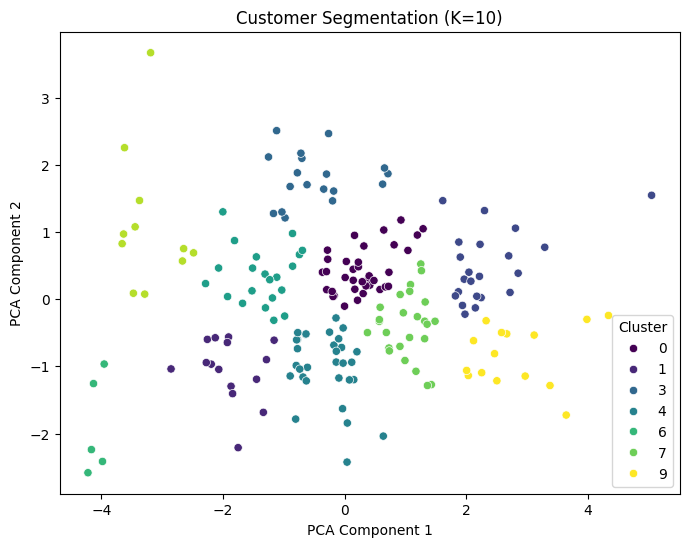

Optimal number of clusters: 10
Davies-Bouldin Index: 0.795757749841043
Silhouette Score: 0.38561838200134424


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the datasets
customers_df = pd.read_csv(r"C:\Users\harsh\Downloads\Customers.csv")
products_df = pd.read_csv(r"C:\Users\harsh\Downloads\Products.csv")
transactions_df = pd.read_csv(r"C:\Users\harsh\Downloads\Transactions (1).csv")

# Convert date columns to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Merge datasets for analysis
merged_df = transactions_df.merge(customers_df, on='CustomerID').merge(products_df, on='ProductID')

# Ensure correct column names
price_column = 'Price_x' if 'Price_x' in merged_df.columns else 'UnitPrice' if 'UnitPrice' in merged_df.columns else None

# Feature Engineering
aggregation_dict = {
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'ProductID': 'nunique',
    'TransactionDate': ['min', 'max']
}
if price_column:
    aggregation_dict[price_column] = 'mean'

customer_features = merged_df.groupby('CustomerID').agg(aggregation_dict).reset_index()

# Renaming columns dynamically
column_names = ['CustomerID', 'TotalValue', 'Quantity', 'UniqueProducts', 'FirstPurchase', 'LastPurchase']
if price_column:
    column_names.append('AvgPrice')
customer_features.columns = column_names

customer_features['CustomerLifetime'] = (customer_features['LastPurchase'] - customer_features['FirstPurchase']).dt.days
customer_features.drop(columns=['FirstPurchase', 'LastPurchase'], inplace=True)

# Prepare features for clustering
feature_cols = ['TotalValue', 'Quantity', 'UniqueProducts', 'CustomerLifetime']
if price_column:
    feature_cols.append('AvgPrice')

# Normalize data
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features[feature_cols])

# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
customer_features_pca = pca.fit_transform(customer_features_scaled)

# Determine optimal number of clusters
db_scores = {}
silhouette_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(customer_features_pca)
    db_scores[k] = davies_bouldin_score(customer_features_pca, labels)
    silhouette_scores[k] = silhouette_score(customer_features_pca, labels)

# Find the best cluster count
optimal_clusters = min(db_scores, key=db_scores.get)
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_features['Cluster'] = kmeans.fit_predict(customer_features_pca)

# Visualization of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_features_pca[:, 0], y=customer_features_pca[:, 1], hue=customer_features['Cluster'], palette='viridis')
plt.title(f'Customer Segmentation (K={optimal_clusters})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Save clustering results
customer_features[['CustomerID', 'Cluster']].to_csv('Customer_Segmentation.csv', index=False)

# Print clustering metrics
print(f'Optimal number of clusters: {optimal_clusters}')
print(f'Davies-Bouldin Index: {db_scores[optimal_clusters]}')
print(f'Silhouette Score: {silhouette_scores[optimal_clusters]}')
